# 1. Introduction 

Collateral Reblance Pool (CRP) dynamically rebalances Collateral to ensure the ayToken minted (i.e. the loan) remains solvent, especially in an adverse market environment (i.e. the value of the loan does not exceed the value of Collateral). This dynamic rebalancing, together with a careful choice of the key parameters (including loan to Loan-to-Value (LTV) and volatility assumption) allows ALEX to eliminate the liquidation needs. Any residual gap risk (which CRP cannot address entirely) is addressed through maintaining a strong reserve fund. When a Borrower mints ayToken by providing appropriate Collateral, the Collateral is converted into a basket of Collateral and Token, with the weights determined by CRP.


# 2. CRP dynamic rebalance mechanism 

The following diagram illustrates how CRP dynamic rebalances with the weights determined by CRP.  At the beginning of each day (Time 0), the pool updates new weights based on a CRP rebalceing strategy (session 3.1), then the pool will be rebalanced by Power Arbitrageur to bring the spot price back to the market price. Right before the end of day, the oracle price is usded to update the rebalanceing weight for the next day (Time 1).  We leave the mathematical formula of how to calculate the weight to the last session.    
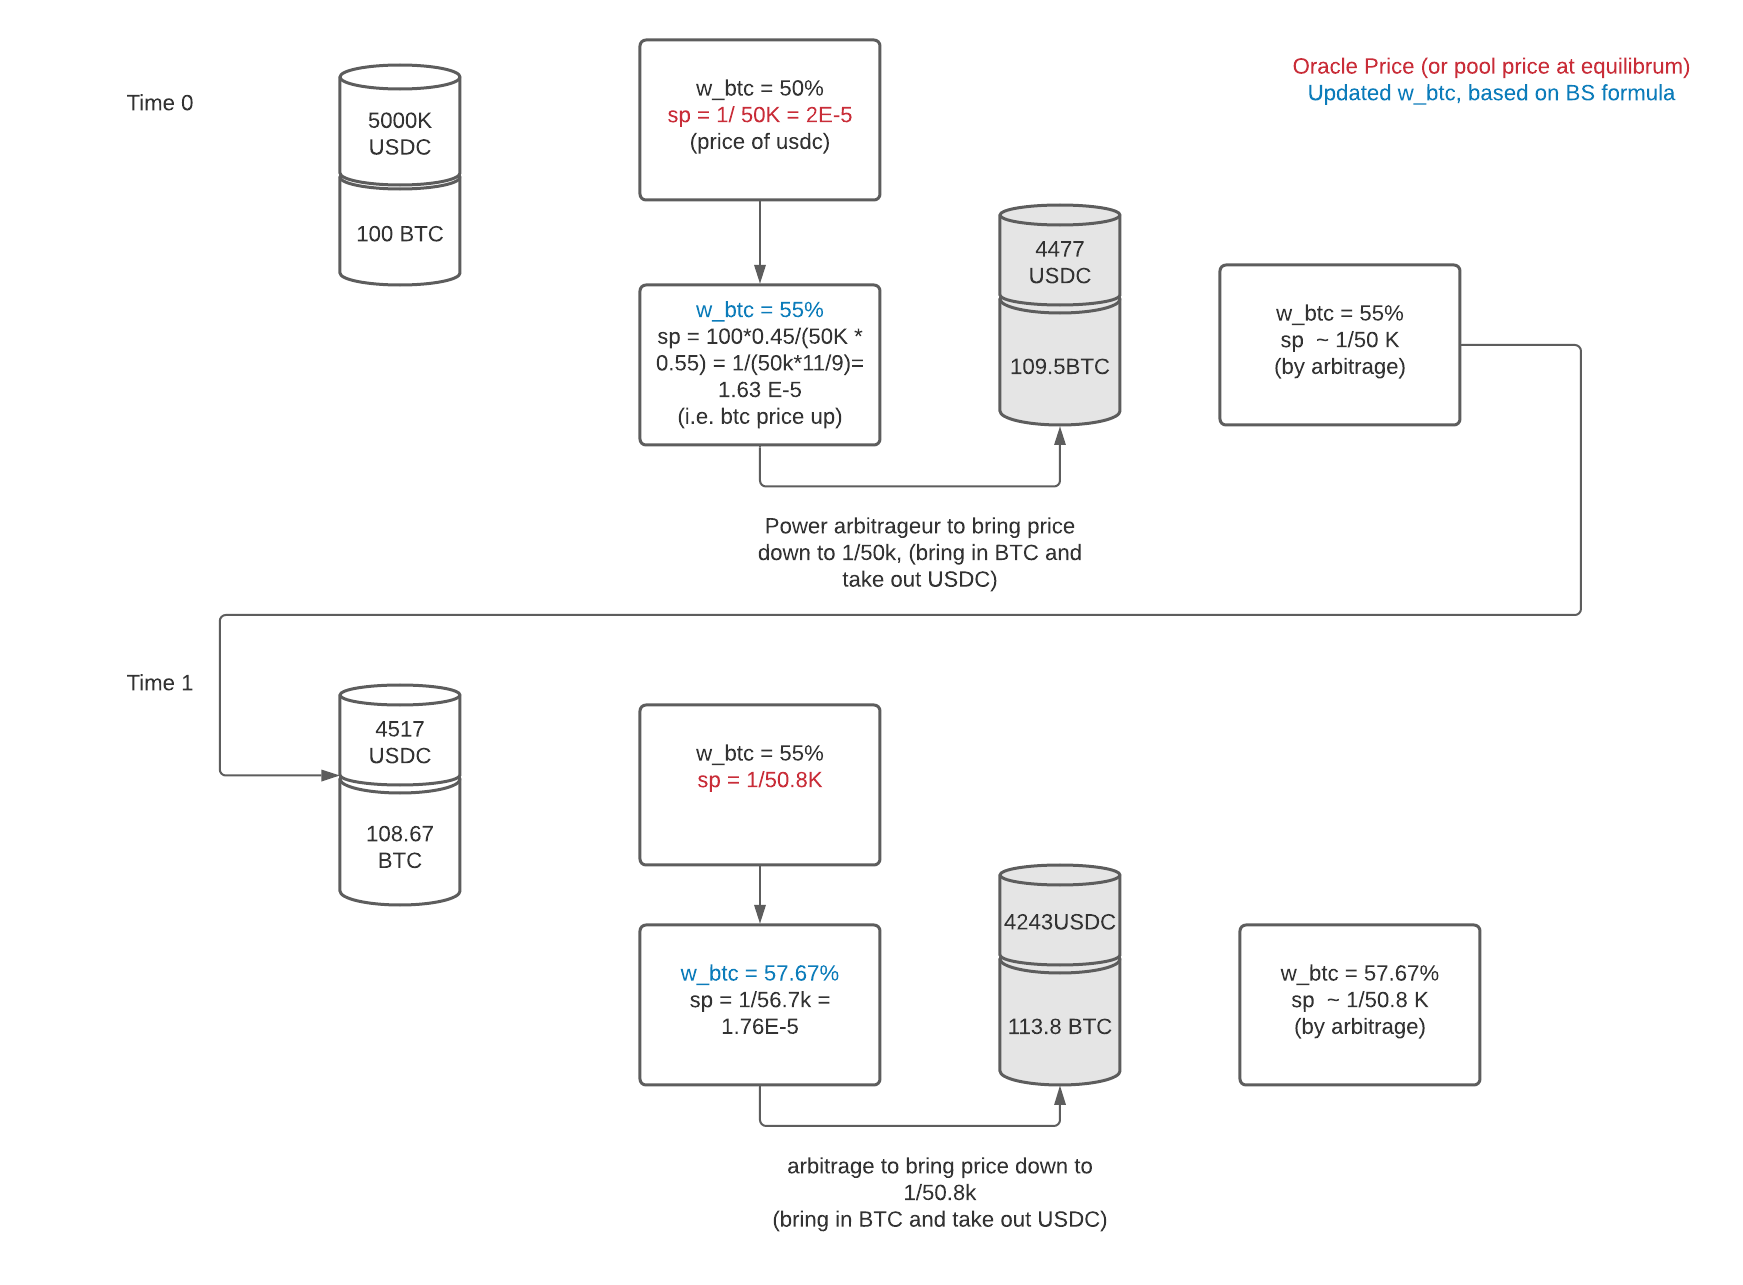


# 3.  CRP performance by Simulations  

In this notebook, we create a CRP simulation visulization to help you understand the key attributes of the CRP pool based on different parameters.  The interactive chart will show you:    

1.  How does CRP achieve the dynamic rebalances with weights determined by CRP? 
2.  In which parameters space (including LTV, volatility assumption, and power arbitrageur functions) and the CRP would maintain a low default risk and a high pool-value level to a collateral ratio (PVCR), in different market environments?  

Basically, a CRP would serve as an agent (bot) response to the actual market environment by updating the pool weight based on current token price $p$, actual price volatility $\eta$, and estimated price volatility $\sigma$.  We simplify the market environment and let the token price change follow a linear growth trend with variation, formally named the Geometric Brownian Motion (https://en.wikipedia.org/wiki/Geometric_Brownian_motion).  By setting up different growth rates $r$ and volatility $\eta$, we can approximately mimic different market environments.  

Two metrics a liquidity provider (LP) would be very interested to know are 1) the chance of default, i.e., when the LTV >1 at any time point, and 2) Impermanent loss defined as Pool Value to the Collatral hold outside the pool ratio (PVTC).  We can empirically estimate the default risk and confidence intervals of PVTC for any given parameters by conducting Monte Carlo simulations. 

### 3.1 Weights rebalencing strategy

Four weights rebalencing strategies are condisered in this simulation study. 

1. Strictly folloiwng BS option model. 

2. Smooth the weigts changes using moving average (MA) of the BS weights.

3. Smooth the weights using exponential average.  

4. A fixed 50/50 pool serving as reference  

For simplicity, token APY are not considered for now. We set initial weights to be 50/50 and loan lifetime equals 3 months, and all key parameters various in the following parameters space: 
### 3.2 Pool parameters 

   (1) Initial LTV: range from 0.7 to 0.95
    
   (2) Black-scholes volatility: $\sigma$ range from 10% - 100%  
   
   (3) Rebate rate of the power arbitargeur: 0 - 100% 
   
   (4) Fee paid based on percentage to weights change: 0% - 1% 
   
   (5) Moving average (MA) of rebalnacing weights: 1 - 30 

### 3.3 Market enviroment        
   (6) Growth rate: $r$ range from $[-2, 2]$ (corresponding to 25% or 200% of the initial price)
   
   (7) Growth rate volatility: $\eta$ range from 10% - 100%
   
  

### 3.4 Episode 

For each parameter setup (1) to (7), we activate the CRP and monitor its performance during the whole loan life term (called an episode). At each scheduled time point t (e.g. daily), we rebalance Collateral and token according based on different strategy and record the key pool metrics: 

1. Token price at time t 
2. Reblanced weight at time t 
3. Pool Values at t, including rebate and fee
3. LTV: Defaul if LTV > 1.  
4. PVTC  


In [1]:
# plot of liquity 
import scipy 
import matplotlib.pyplot as plt
import matplotlib.animation
from matplotlib.widgets import Slider
import seaborn as sns
import numpy as np 
import random
import pandas as pd 
from ipywidgets import *
from scipy.stats import norm

#Import simulation function and class 
%run rbpool_env_v3.ipynb


In [3]:
help(get_episode_full)

Help on function get_episode_full in module __main__:

get_episode_full(t, y_price_init, bs_vol, Growth_rate, Real_vol, Collateral, LTV0, fee_rate, rebate_rate, pool_init_x, pool_init_y, pool_init_wx, price_source, *args)
    Purpuse: 
        generate one simulation based on selected parameters and random price change following the Browian motion.  
        pool attributes are rescorded at each step. 
        Rebate and fee values are back to the pool. 
    
    Input: 
        - t: term of the loan (e.g. 90 days)
        - y_price_init: initial price of loan token (e.g. btc = 50000 USD) 
        - bs_vol: black shoral option volatilty 
        - Growth_rate: linear growth slope of y price 
        - Real_vol: growth Brownie motion volatility 
        - Collateral amount (e.g. 200 BTC) 
        - LTV0: Initial LTV (e.g. 90%)
        - fee_rate: e.g. 0.15% of absolute weight changes 
        - rebate_rate: e.g. 50% impermanent loss due to rebalance weigths 
        - pool_init_x: Initi

In [5]:

# an episode example  
# Set_random_seed to True, to ensure one path of random work.  It helps to evaluate the impact of parameter changes 
# set_radom_seed to False, you will have different random path when slide parameters. 
set_random_seed = True 
t =  np.linspace(91,0,92)/365
Real_vol = 0.5
Growth_rate = 0
LTV0 = 0.8
bs_vol = 0.5
y_price_init = 50000
Collateral = 10000000
pool_init_x = 5000000 
pool_init_y = 100
pool_init_wx = 0.5
fee_rate = 0.0015
rebate=0.5
price_source = [0]
example = get_episode_full(t,y_price_init, bs_vol, Growth_rate, Real_vol, Collateral, LTV0, fee_rate, rebate,
                      pool_init_x, pool_init_y, pool_init_wx,price_source, '50/50')

<IPython.core.display.Javascript object>


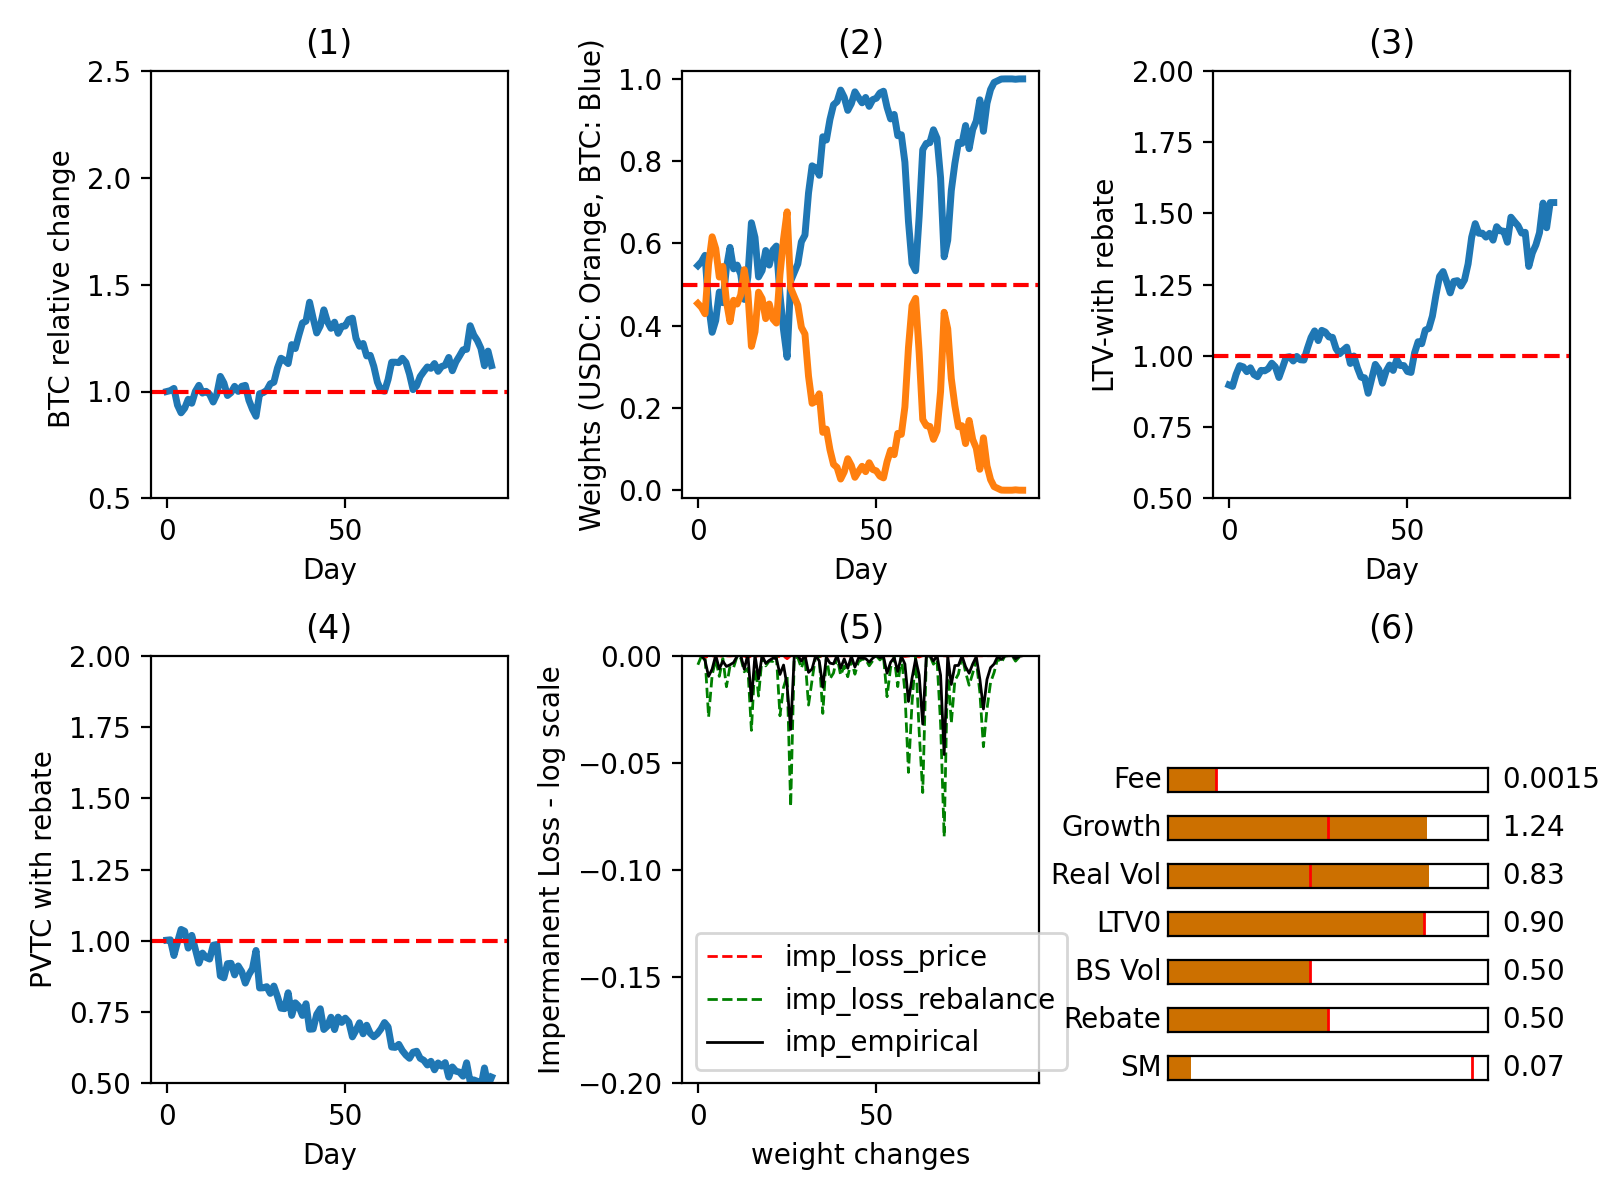

C:\Users\jings\Anaconda3\lib\site-packages\ipykernel_launcher.py:155: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [6]:
episode_plot(['y_price', 'weights_ytoken', 'ltv_with_rebate', 'pvtc_rebate', \
              'imp_loss_price', 'imp_loss_rebalance', 'imp_empirical' ], 'SM' ,0.95)